# Udacity Machine-Learning Engineer Nanodegree 
# Capstone Project

### Eric G. Cavalcanti

18 August 2018

## I. Definition

### Project Overview

The aim of this project is to use machine learning techniques to estimate photon counts from the output of a transition-edge sensor (TES) detector illuminated by laser light. Transition-edge sensors provide, among other applications, unprecedented sensitivity for photon-number resolved optical detection, with applications in quantum information and computation technologies \cite{Smith2012, Christensen2013}. The capability of accurately and efficiently resolving photon numbers with TES detectors has the potential to open up higher-dimensional applications in optical quantum information processing.

TES detectors provide the highest efficiencies among photon-number resolving detectors \cite{Eisaman2011}. One of the drawbacks of these sensors however are the slow response times and thus low detection rates. One of the motivations for this project is to explore whether machine learning techniques could provide insights on the structure and classification of TES traces, that could potentially translate into hardware-based classification of photon numbers and accelerate detection rates.

Further details on the TES detector used for this project can be found in an introductory set of notes \cite{Gillett2018}, available in \href{https://github.com/egcavalcanti/machine-learning}{https://github.com/egcavalcanti/machine-learning}, under \code{projects/capstone/photon\_detector/TES\_introductory\_material.pdf}.


### Problem Statement

The data utilised in this project was produced by Geoff Gillett from the University of Queensland's Quantum Technology Laboratory. The dataset contains of a collection of output signals ("traces") produced by a TES illuminated by a laser source. As the energy of a pulse is proportional to the number of photons, photon numbers in a trace have been estimated via the area of the signal (and thus its energy). The distribution of pulse areas for each photon number value follows a slightly skewed Gaussian distribution. For low photon numbers, an estimate of photon numbers via pulse area appears to be quite accurate as the clusters are reasonably well separated. For higher photon numbers however, there is considerable overlap between the clusters, and thus an estimate by area alone seems to be insufficient to fully resolve photon counts. 

The goal of the present analysis is to explore whether unsupervised learning techniques can provide an improvement on these estimates. A solution to the problem presented in this project would be a classification of the traces in the dataset into clusters corresponding to pulse photon numbers. Given that the pulse area follow approximately Gaussian distributions, an appropriate technique for this task is Gaussian Mixture Model (GMM) clustering. I will also apply Principal Component Analysis to reduce the 2048-dimensional pulse intensity vectors into a lower-dimensional space, to better visualise how features apart from the area can separate the data into photon-number clusters. I will compare the clustering produce with this technique with the area classification using the metric discussed in the following subsection.


### Metrics 

Unfortunately, there is no independent estimate of the photon number in a particular pulse apart from the pulse area. This makes it impossible to determine the "true" number of photons detected by any given pulse. However, since the photon source produces optical coherent states, it is expected that the photon numbers follow a Poissonian distribution. For a coherent state the probability of detecting $n$ photons in a given time interval is given by:

$$
P(n) = e^{-\langle n \rangle} \frac{\langle n \rangle^n}{n!} \;,
$$

where $\langle n \rangle$ is the expected number of photons in that interval. This can therefore serve as a metric to compare the technique produced as part of this work with the direct estimate via trace areas: ideally, this classification would be closer to a Poissonian distribution than the benchmark classification, indicating that it is closer to the expected photon-number distribution of the coherent laser source. 

However, the GMM clustering classification was not appreciably superior to the benchmark as far as this metric is concerned. This was likely partly due to the limited size of the dataset used here, and thus low statistics for large photon numbers. On the other hand, as I will discuss in the following sections, the visualisation of the clusters based on the PCA component analysis give some evidence that the present clustering classification is more accurate; the small difference as far as the Poissonian distribution is concerned could be due to data points in neighbouring clusters swapping clusters while keeping ratios relatively unchanged. The results in this exploratory project indicate that this analysis merits further exploration with a larger dataset. 

## II. Analysis

### Data exploration

The TES data to be utilised in this work was produced by Geoff Gillett at the University of Queensland QT Lab, and permission has been given by that author to use the data in this work, and for its publication on Github. The directions to download the dataset are given in the README.md file found in https://github.com/egcavalcanti/machine-learning, under projects/capstone/photon\_detector. 

The file TES\_dataset.npz contains several numpy arrays as specified below:


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# load data from the file
fileset = np.load('TES_dataset.npz')
traces = fileset['trace'] # a np record array of 3*10^5 captured traces and includes energy measurements.
hist = fileset['raw_hist'] # a histogram created  from 3x10^7 area measurements taken 
                           # with the same optical input as the traces.
x = fileset['hist_x'] # the trace area (~energy) values at the center of the histogram bins.
f = fileset['smooth_hist'] # raw_hist smoothed using a Gaussian filter.
peaks = fileset['peaks'] # a sequence of slices that divide the histogram data into 12 distinct peaks, 
                         # based on the mid point between maxima.
max_i = fileset['max_i'][:12] # the indices of the first 12 peaks in the smoothed histogram.
stds = fileset['std'] # the std deviations of the first 12 peaks estimated from the FWHM.
means = x[max_i] # the means of the first 12 Gaussians.

The distribution of the energy measurements (area) was modelled in the input dataset as a mixture of 12 normal distributions. The data appears to be a mixture of skew-normal distributions but the Gaussian approximation is adequate to classify the traces. 

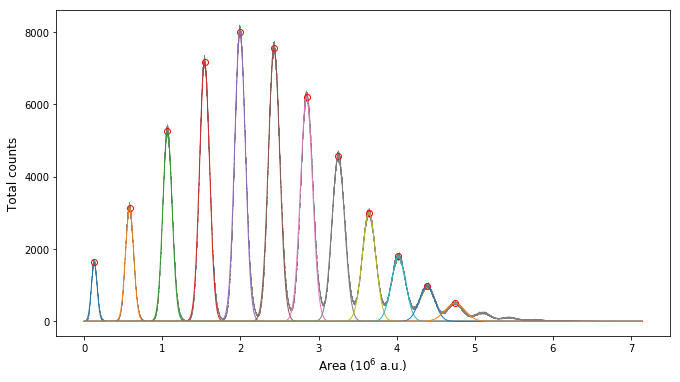

In [31]:
from scipy.stats import norm
#%matplotlib notebook

plt.figure(figsize=(11,6))
plt.plot(x, hist, color='gray', lw=0.5, zorder=0) # raw histogram
plt.plot(means, f[max_i], 'or', markerfacecolor='none') # red circles at maxima of smooth_hist
for i in range(len(max_i)):
    g = norm.pdf(x, means[i], stds[i]) * f[max_i[i]] * stds[i] * np.sqrt(2 * np.pi)
    plt.plot(x, g, lw=1) # the Gaussians
plt.xlabel('Area ($10^6$ a.u.)', fontsize=12)
plt.ylabel('Total counts', fontsize=12)
plt.xticks([0,1000000,2000000,3000000,4000000,5000000,6000000,7000000],[0,1,2,3,4,5,6,7])
plt.show()

Below I print the field names in the 'traces' numpy array, and the values of the fields for the first entry in the array. The actual output trace is given in the 'samples' field, and the plot of the first 5 traces is given below.  The histogram above was produced from 3 x 10^7 data points, whereas the data in 'traces' contains 3 x 10^5 traces only. Therefore it is expected that this exploratory analysis may not necessarily produce more accurate results than the benchmark.

The other fields could potentially be useful as features for unsupervised learning as well, but I will not consider them in this work, but rather concentrate on the raw output in 'samples', since one of the goals of this work is to determine whether some fast, built-in hardware processing can be used to accelerate the output of a TES, and thus none of that post-processed data would be available for this purpose.

('size', 'tflags', 'eflags', 'time', 'area', 'pulse_length', 'pre_trigger', 'rises', 'dot_product', 'samples')
size 4136
tflags [  0 229]
eflags [16 13]
time 10003
area 1481619
pulse_length 554
pre_trigger 0
rises [(25099, 64697, 130, 0) (14447, 14717,   0, 0)]
dot_product 205527284757
samples [ 5751  6022  6295 ... -1335 -1338 -1341]


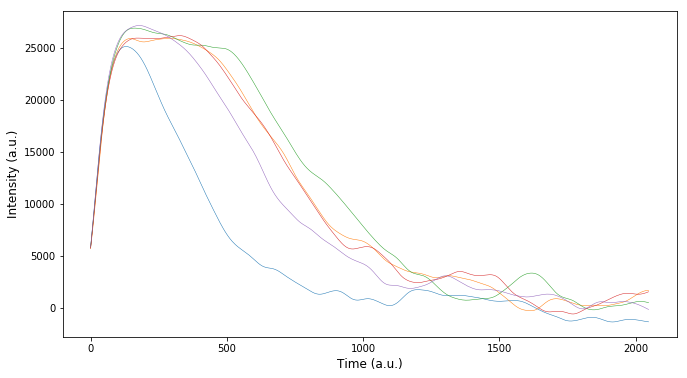

There are  30022 traces in this dataset, each composed of a series of 2048 pulse intensity values


In [35]:
#%matplotlib notebook

print(traces.dtype.names) # the field names in the 'traces' numpy array
for i in range (1):
    for name in traces.dtype.names:
        print(name, traces[i][name])

plt.figure(figsize=(11,6))
for t in traces[:5]['samples']: # plot the first 100 members of the class
        plt.plot(t, lw=0.5)

plt.xlabel('Time (a.u.)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.show()

print('There are ', traces['samples'].shape[0], 'traces in this dataset, each composed of a series of', traces['samples'].shape[1], 'pulse intensity values')

We see that the traces are characterised by a sharp rise, sometimes followed by a plateau, then a slower decline in intensity, with a noisy extended tail.

#### Classifying the traces by area

In [37]:
def classify(w, fill=True):
    """
    w is a list of widths (in std devations) about the mean of a peak in the area histogram.
    w=0 uses the whole peak and the extent of a peak is defined by the mid points between the maxima.
    the length of w determines the number peaks used to create the classes, the maximum is 12.
    
    returns a list of recarrays, one for each class, where n is the number of traces in the class
    
    fill=True specifies whether to create a final class for all pulses at the trail end of the spectrum.
    """
    w = np.array(w) * stds[:len(w)]
#    print(w)
    ranges = [(x[p.start],x[p.stop]) if w==0.0 else (m-w,m+w) \
              for p,m,w in zip(peaks, means, w)]
    if fill:
        ranges.append((x[peaks[len(w)-1].stop],x[len(x)-1]))
#   print(ranges)
    return [traces[np.where((traces['area'] >= r[0]) & (traces['area'] < r[1]))] \
            for r in ranges]

def count(classes):
    """
    return a list containing the number of traces in each class.
    """
    return [c.shape[0] for c in classes]

### Exploratory Visualisation

Using the benchmark area classification, the traces dataset has been classified into 13 classes, one for each of the first 12 photon numbers, and the (optional) last corresponding to photon numbers larger than or equal to 13.

[197, 517, 981, 1488, 1718, 1709, 1540, 1171, 861, 515, 304, 205] 11206


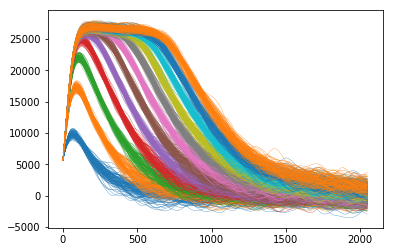

In [38]:
#%matplotlib notebook

classes = classify(np.ones((12,))*0.5, fill=False) # classify using 0.5 std deviation 
                                                   # either side of the means
for c in classes:
    p = None # to control the colour cycling
    for t in c[:100]['samples']: # plot the first 100 members of the class
        if p is None:
            p, = plt.plot(t, lw=0.3)
        else:
            plt.plot(t, lw=0.3, color=p.get_color())
            
print(count(classes), sum(count(classes)))

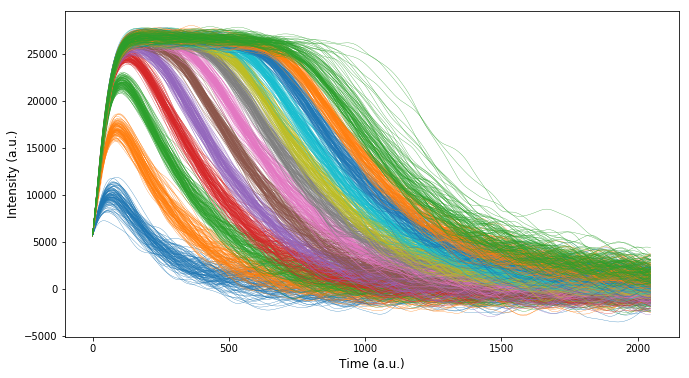

[485, 1342, 2613, 3889, 4545, 4629, 4148, 3209, 2254, 1332, 814, 417, 344] 30021 30022


In [40]:
#%matplotlib notebook

classes = classify(np.zeros((12,)), fill=True) # classify using the full peak width
                                               # the photon number for classes[n] is n+1

plt.figure(figsize=(11,6))
plt.xlabel('Time (a.u.)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
for c in classes: # iterate over the classes
    p = None # to control the colour cycling
    for t in c[:100]['samples']: # plot the first 100 traces in the class
        if p is None:
            p, = plt.plot(t, lw=0.3)
        else:
            plt.plot(t, lw=0.3, color=p.get_color())
plt.show()

# print the number of traces in each class and the total number of classified traces, and the total number of traces
print(count(classes), sum(count(classes)), traces['samples'].shape[0])

## III. Methodology

### Data Preprocessing

We first look for outliers in the data below, and remove a clear outlier.

There is a clear outlier at index  14083 with an area value of  7449593


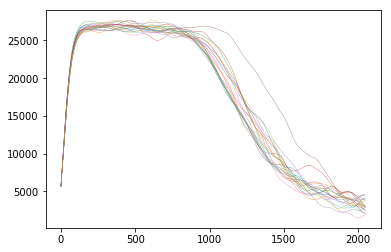

In [41]:
#%matplotlib notebook

for t in traces[np.where(traces['area'] > 6000000)]:
    plt.plot(t['samples'], lw=0.3)

print("There is a clear outlier at index ", np.argmax(traces['area']), "with an area value of ", np.amax(traces['area']))

In [42]:
traces = traces[traces['area']!=7449593] # removing the outlier

In [43]:
traces.shape[0] # double-checking that one element was removed

30021

Next I'll calculate the means of the traces in each class. This will later be used to initialise the clustering algorithm.

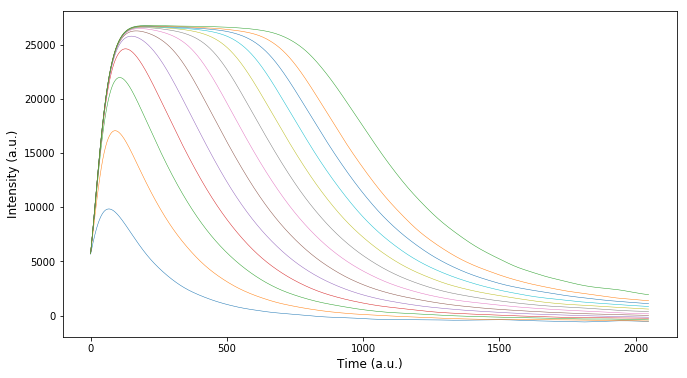

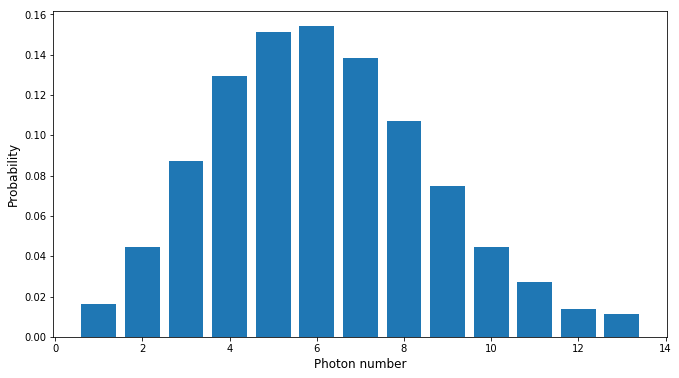

In [46]:
#%matplotlib notebook

classes = classify(np.zeros((12,)), fill=True) # re-classify since the outlier was removed

mean_traces = np.zeros((len(classes), 2048)) # initialising array of mean traces

i = 0
for c in classes:
    mean_traces[i] = np.average(c['samples'], axis=0) # calculating the mean traces for each class
    i += 1

plt.figure(figsize=(11,6))
plt.xlabel('Time (a.u.)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
for t in range(len(classes)): # plotting mean traces
    plt.plot(mean_traces[t], lw=0.5)
plt.show()

class_weights = np.divide(count(classes), traces['samples'].shape[0]) # calculating the weights for each class

plt.figure(figsize=(11,6)) # create new figure for photon-number histogram
plt.xlabel('Photon number', fontsize=12)
plt.ylabel('Probability', fontsize=12)
n_photons = list(range(1,len(classes)+1)) # n_photons for the x-axis
plt.bar(n_photons, class_weights) # plotting the class weight as a bar histogram
plt.show()

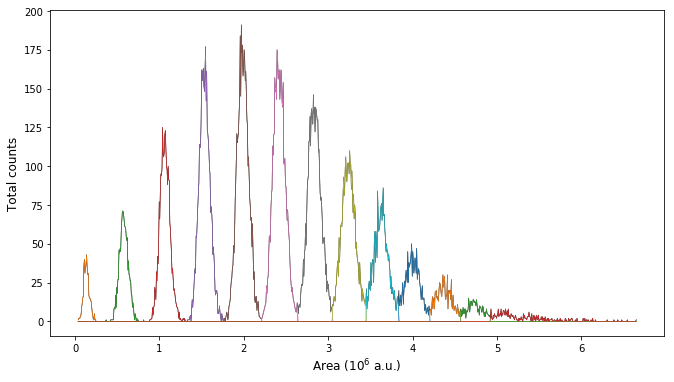

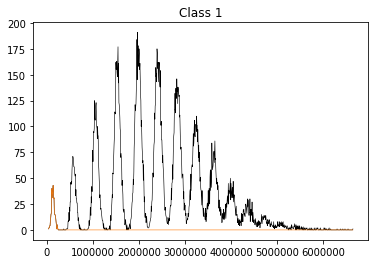

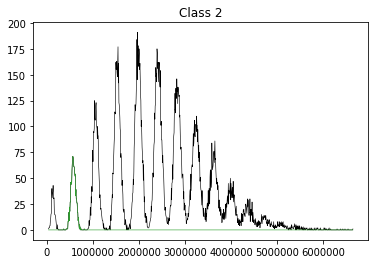

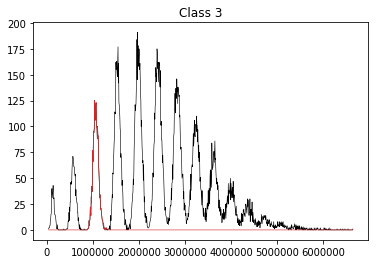

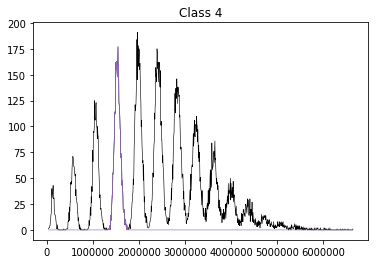

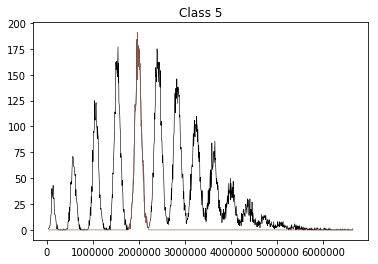

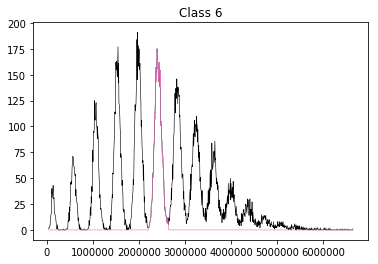

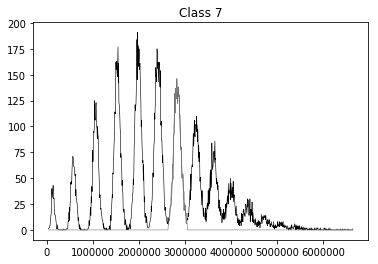

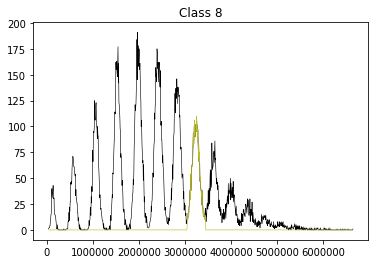

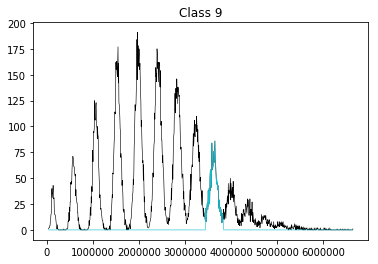

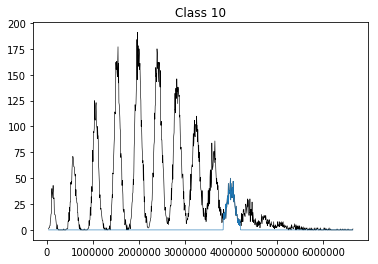

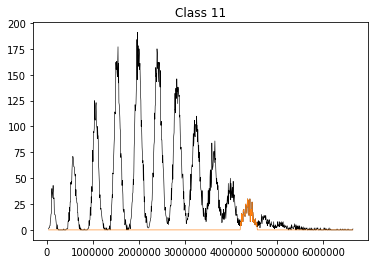

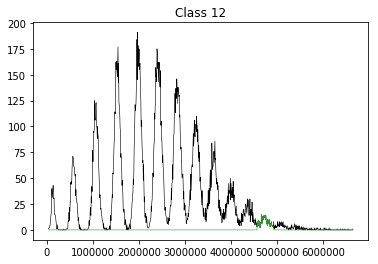

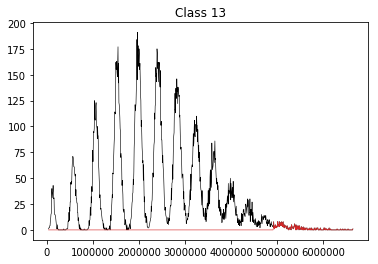

In [71]:
#%matplotlib notebook

#Creating a histogram for the whole data
area_hist, bin_edges = np.histogram(traces['area'], bins=1000)
bin_x = [(bin_edges[i+1] + bin_edges[i])/2 for i in range(len(bin_edges)-1)]
plt.figure('all_classes', figsize=(11,6))
plt.plot(bin_x, area_hist, color='black', lw=0.6)

#Using the same bin_edges to create individual histograms for each class
i = 0
for c in classes:
    i += 1
    #calculating a histogram for each class
    area_hist_i, bin_edges_i = np.histogram(c['area'], bins=bin_edges)
    
    #plotting each cluster in the 'all' figure
    plt.figure('all_classes')
    plt.xlabel('Area ($10^6$ a.u.)', fontsize=12)
    plt.ylabel('Total counts', fontsize=12)
    plt.xticks([0,1000000,2000000,3000000,4000000,5000000,6000000],[0,1,2,3,4,5,6])
    color_code = 'C' + str(i%10)
    plt.plot(bin_x, area_hist_i, color=color_code, lw=0.6)

    
    #plotting each cluster in a separate figure
    plt.figure(str(i))
    titlei = 'Class ' + str(i)
    plt.title(titlei)
    plt.plot(bin_x, area_hist, color='black', lw=0.6)
    plt.plot(bin_x, area_hist_i, color=color_code, lw=0.6)  


### Implementation

The implementation proceeded by applying scikit-learn GaussianMixture unsupervised learning algorithm to the dataset in traces['samples']. The trained clusterer was then applied to the whole data and the cluster values for each trace were stored as an appended field in the record array, traces['cluster']. I initially varied the n\_components parameter between 9 and 14, comparing their silhouette scores, to obtain some idea about how well the algorithm performs with different numbers of clusters. However, this approach didn't seem to work well as for any value less than 12 the clusters tended to group together several of the photon-number peaks. Since we have a very good indication of roughly where the clusters are supposed to be, the idea of measuring their fitness by comparing silhouette scores seemed pointless -- a visual inspection reveals already a much better comparison. 


In [64]:
import time
start_time = time.time()

from sklearn.mixture import GaussianMixture
#from sklearn.metrics import silhouette_score

# create array from traces data
data = traces['samples']

# Apply GMM clustering algorithm to data 
n_clusters = 13
clusterer = GaussianMixture(n_components=n_clusters, n_init=1, verbose=True).fit(data)

# Predict the cluster for each data point
preds = clusterer.predict(data)
print("--- %s seconds ---" % (time.time() - start_time))

Initialization 0
  Iteration 0
Initialization converged: True
--- 511.0307309627533 seconds ---


Below I add the cluster predictions as another field in the 'traces' recarray, and plot the traces with the color code corresponding to its cluster.

In [65]:
from numpy.lib import recfunctions
traces = recfunctions.append_fields(traces, ['cluster'], [preds], dtypes=np.int16, \
                                           fill_value=0, usemask=False, asrecarray=True)

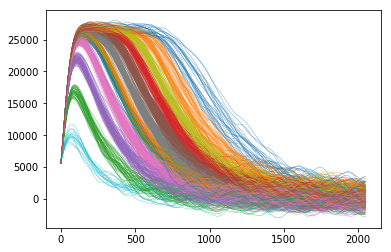

In [66]:
#%matplotlib notebook

for t in traces[:1000]:
    color_code = 'C' + str(t['cluster']%10)
    plt.plot(t['samples'], lw=0.3, color=color_code)

As we can see above, the initial GMM clusters clearly underperforms the benchmark area classification. 

To better visualise the clusters, I will plot a distribution of the areas for each cluster.

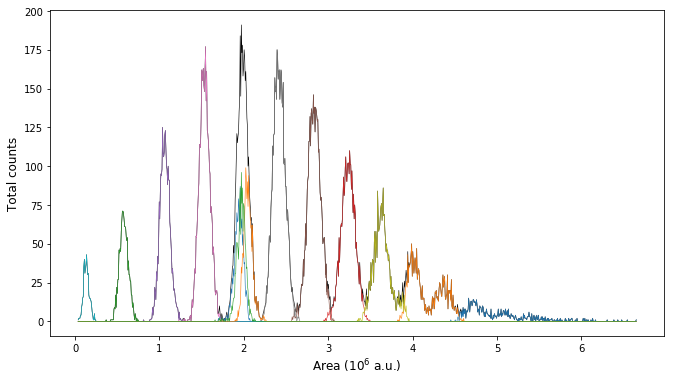

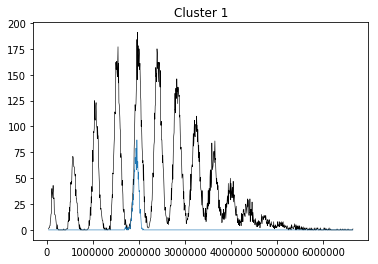

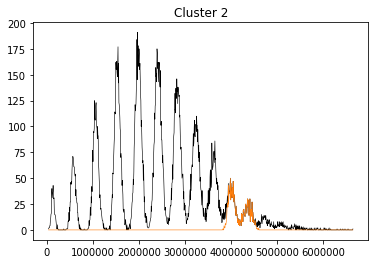

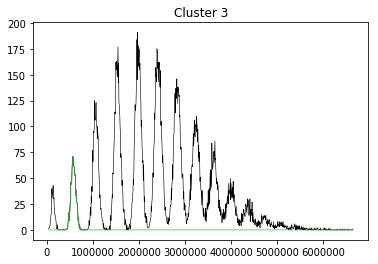

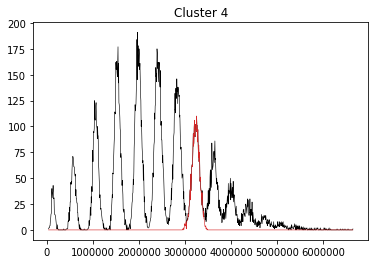

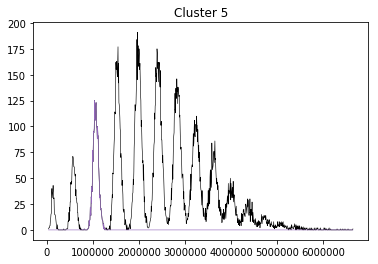

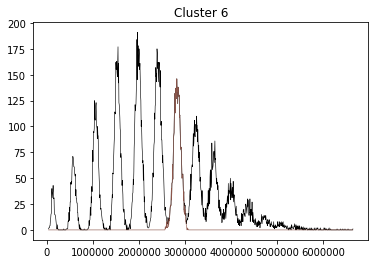

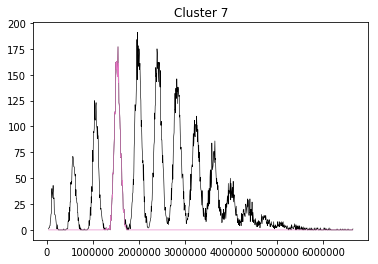

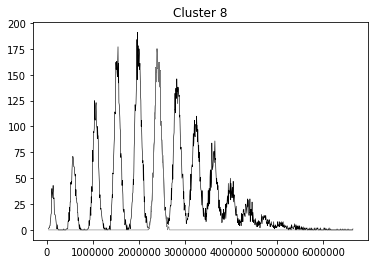

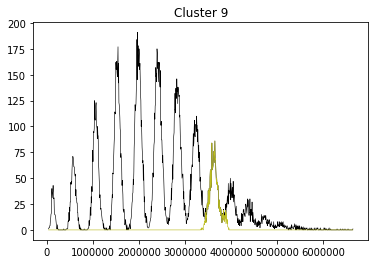

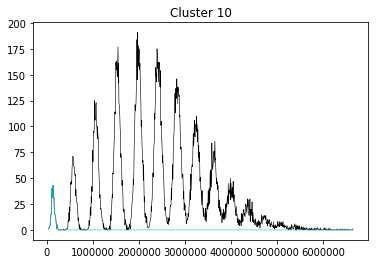

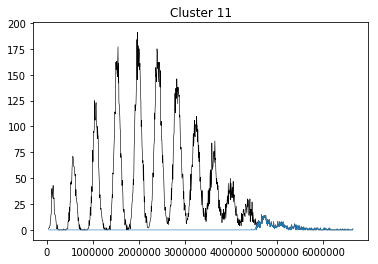

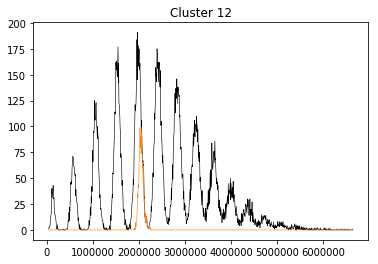

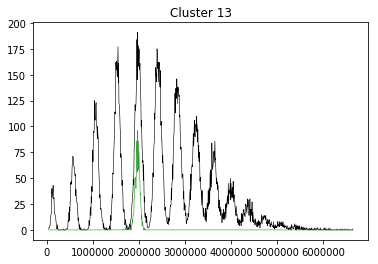

In [73]:
#%matplotlib notebook

#Creating a histogram for the whole data
area_hist, bin_edges = np.histogram(traces['area'], bins=1000)
bin_x = [(bin_edges[i+1] + bin_edges[i])/2 for i in range(len(bin_edges)-1)]
plt.figure('all_clusters', figsize=(11,6))
plt.plot(bin_x, area_hist, color='black', lw=0.6)

#Using the same bin_edges to create individual histograms for each cluster
for i in range(n_clusters):
    #calculating a histogram for each cluster
    area_hist_i, bin_edges_i = np.histogram(traces[np.where(traces['cluster'] == i)]['area'], \
                                         bins=bin_edges)
        
    #plotting each cluster in the 'all' figure
    plt.figure('all_clusters')
    plt.xlabel('Area ($10^6$ a.u.)', fontsize=12)
    plt.ylabel('Total counts', fontsize=12)
    plt.xticks([0,1000000,2000000,3000000,4000000,5000000,6000000],[0,1,2,3,4,5,6])
    color_code = 'C' + str(i%10)
    plt.plot(bin_x, area_hist_i, color=color_code, lw=0.6)
    
    #plotting each cluster in a separate figure
    plt.figure(str(i+1))
    titlei = 'Cluster ' + str(i+1)
    plt.title(titlei)
    plt.plot(bin_x, area_hist, color='black', lw=0.6)
    plt.plot(bin_x, area_hist_i, color=color_code, lw=0.6)

We see that there are some niceties and some oddities in the cluster decomposition above. The clusters overlap, maintaining something close to a Gaussian distribution, instead of cutting off half-way between the peaks in the case where we use the area alone. This suggests that the algorithm is finding other features to detect the cluster apart from the area, and should give a more accurate result. However, there are some oddities: Here we see that up to $n=4$, the clusters are well defined, but from there on some peaks can be classified as separate clusters (as in $n=6$) or two separate peaks are classified as a single cluster (as in $n=10$ and $11$).

### Refinement

Next I'll apply dimensionality reduction to the data to see what happens with the clusters. It is expected that the most important dimension will encode the area of the pulse, but the clusters above suggest that there are other relevant dimensions being picked up by the clustering alogorithm. Could applying dimensionality reduction prior to clustering produce more accurate clusters?

####  Dimensionality reduction - Principal Component Analysis

In [74]:
from sklearn.decomposition import PCA

# create data from traces samples
data = traces['samples']

# Apply PCA by fitting the data
n_dimensions = 20

pca = PCA(n_components=n_dimensions)
pca = pca.fit(data)

In [75]:
variance_ratios = pca.explained_variance_ratio_
print(variance_ratios)
print(sum(variance_ratios))
print(sum(variance_ratios[:3]))
print(sum(variance_ratios[:6]))

[8.67911227e-01 8.63616281e-02 1.49471606e-02 5.26844722e-03
 4.55776374e-03 3.99150594e-03 3.39737952e-03 2.21654367e-03
 2.08686858e-03 1.91247803e-03 1.60023457e-03 1.27887209e-03
 7.81246342e-04 6.50212365e-04 5.11227739e-04 4.21522132e-04
 3.46647558e-04 2.84343973e-04 2.38733551e-04 2.02727085e-04]
0.9989667694714377
0.9692200153643149
0.9830377322663397


Almost 99.9% of the variance in the data was explained by 20 dimensions.  Indeed 86.8% of the variance is captured by the first dimension, which we can guess to be correlated with the pulse area. The first 3 dimensions already capture 96.9% and the first 6 capture 98.3% of the variance. Testing with different numbers of dimensions shows that a small number, around n=6, provides very good cluster decomposition. This is a remarkable reduction from a vector in a 2048-dimensional space to a 6-d space.

In [76]:
n_dimensions = 6

pca = PCA(n_components=n_dimensions)
pca = pca.fit(data)

pca_data = pca.transform(data)

To better visualise the PCA components, I plot below a scatterplot matrix between each pair of components. We can see that it brings up some clear clusters, in particular in the scatterplot of PCA 1 vs PCA 2, with the most well-defined clusters being presumably associated with the small photon numbers.

In [77]:
import pandas as pd

# transform pca_data into a pandas dataframe
pca_df = pd.DataFrame(pca_data, columns=['PCA' + str(i+1) for i in range(pca_data.shape[1])])

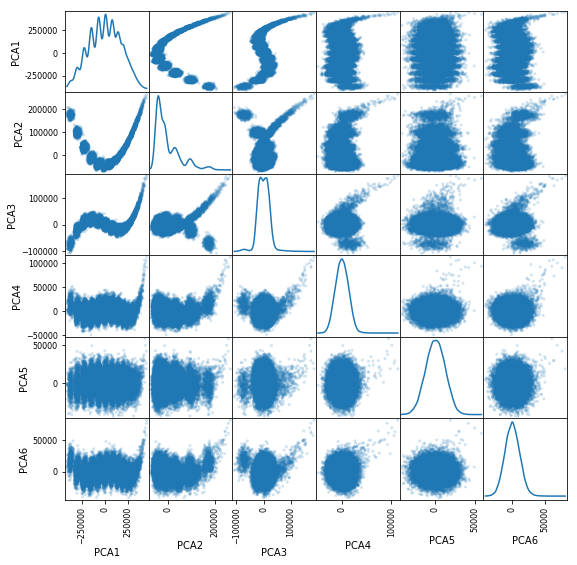

In [79]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(pca_df, alpha=0.2, figsize=(9,9), diagonal='kde');

In [80]:
# Create area dataframe and add pca_dataframe columns
area_df = pd.DataFrame(traces['area'], columns=['Area'])
pca_df = area_df.join(pca_df)

In [81]:
pca_df.head()

,Area,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6
0,1481619,-167026.074390,-17001.721942,36503.798199,-7098.624453,21383.103158,5148.420575
1,3220880,143145.494752,3985.377956,-23506.378447,3976.070503,12835.302312,-4303.774012
2,3633324,192623.259433,25979.848559,-12348.461571,-20153.986744,-21755.266087,-5385.749648
3,3174663,137697.550835,-1941.299886,-24262.346723,-1676.969783,21744.510249,4719.803664
4,2784157,68130.908516,-38579.130933,-3172.488966,2671.512663,8055.865942,14561.566753


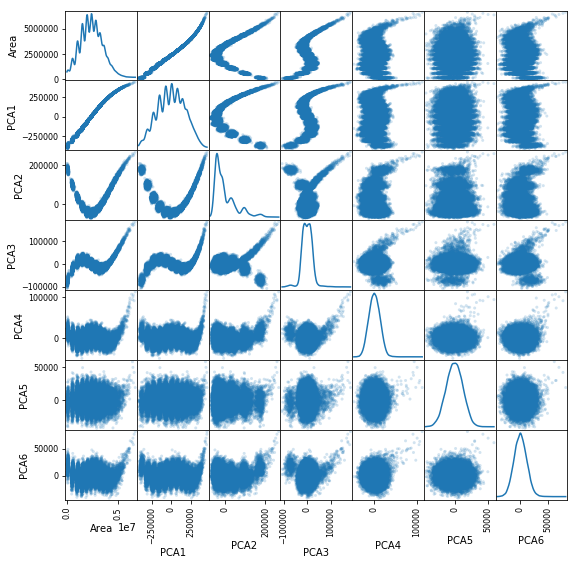

In [82]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(pca_df, alpha=0.2, figsize=(9,9), diagonal='kde');

A 3D visualisation reveals that indeed already with the first 3 PCA dimensions, it is clear that the clusters can be better separated by utilising all three dimensions, and presumably even more so with further information from the other 3.

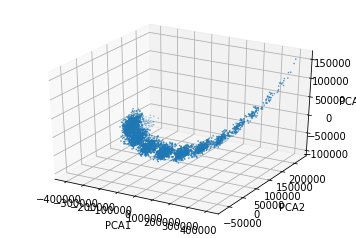

In [85]:
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure().gca(projection='3d')
threedee.scatter(pca_df['PCA1'][:4000], pca_df['PCA2'][:4000], pca_df['PCA3'][:4000], s=0.3)
threedee.set_xlabel('PCA1')
threedee.set_ylabel('PCA2')
threedee.set_zlabel('PCA3')
plt.show()

#### Clustering on reduced data

I will now apply the GaussianMixture algorithm to the reduced data.

In [86]:
from sklearn.mixture import GaussianMixture as GMM
#from sklearn.metrics import silhouette_score

# Apply GMM clustering algorithm to data 
n_clusters = 13
pca_means = pca.transform(mean_traces)
clusterer_pca = GMM(n_components=n_clusters, n_init=50, weights_init=class_weights/sum(class_weights),\
                    means_init=pca_means, verbose=True).fit(pca_data)

# Predict the cluster for each data point
preds_pca = clusterer_pca.predict(pca_data)

Initialization 0
  Iteration 0
Initialization converged: True
Initialization 1
  Iteration 0
Initialization converged: True
Initialization 2
  Iteration 0
Initialization converged: True
Initialization 3
  Iteration 0
Initialization converged: True
Initialization 4
  Iteration 0
Initialization converged: True
Initialization 5
  Iteration 0
Initialization converged: True
Initialization 6
  Iteration 0
Initialization converged: True
Initialization 7
  Iteration 0
Initialization converged: True
Initialization 8
  Iteration 0
Initialization converged: True
Initialization 9
  Iteration 0
Initialization converged: True
Initialization 10
  Iteration 0
Initialization converged: True
Initialization 11
  Iteration 0
Initialization converged: True
Initialization 12
  Iteration 0
Initialization converged: True
Initialization 13
  Iteration 0
Initialization converged: True
Initialization 14
  Iteration 0
Initialization converged: True
Initialization 15
  Iteration 0
Initialization converged: True
In

I now add the PCA cluster predictions to the traces recarray, and plot the new clusters below.

In [87]:
from numpy.lib import recfunctions

traces_pca = recfunctions.append_fields(traces, ['cluster_pca'], [preds_pca], dtypes=np.int16, \
                                           fill_value=0, usemask=False, asrecarray=True)

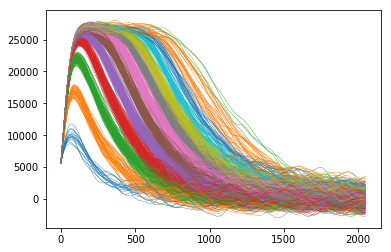

In [88]:
#%matplotlib notebook

for t in traces_pca[:1000]:
    color_code = 'C' + str(t['cluster_pca']%10)
    plt.plot(t['samples'], lw=0.4, color=color_code)

And as before, I plot the histograms corresponding to each PCA cluster.

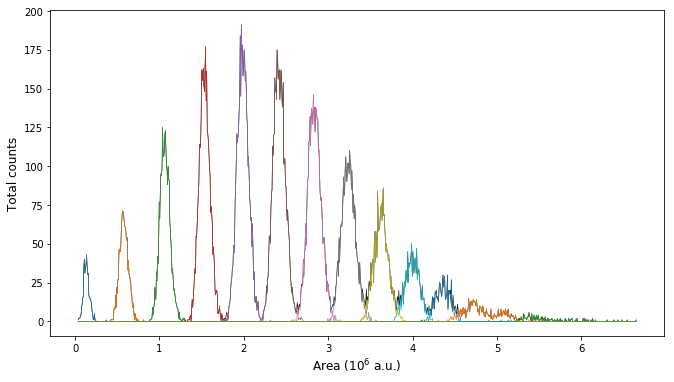

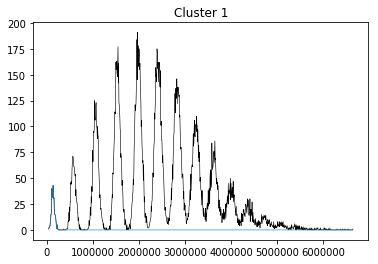

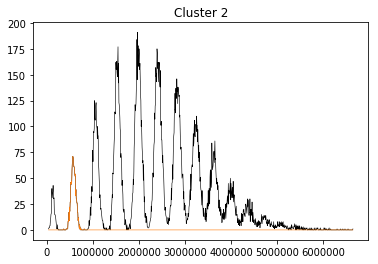

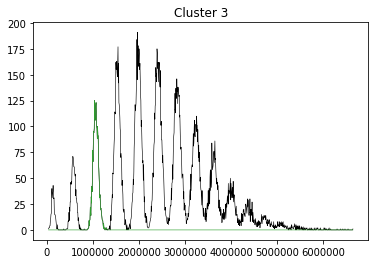

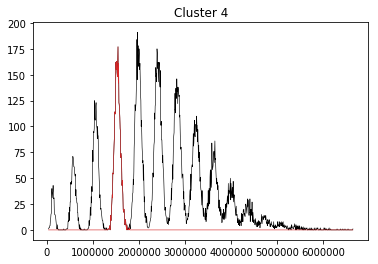

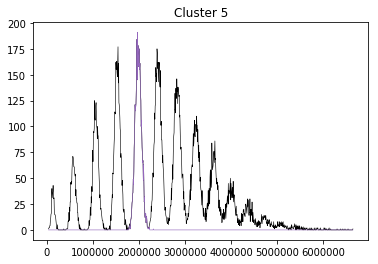

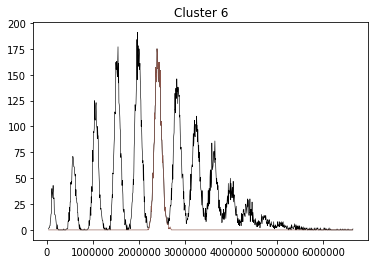

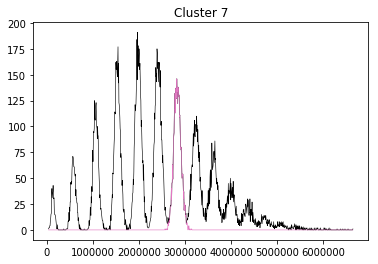

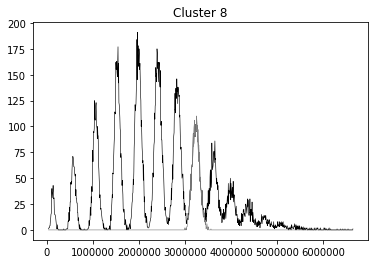

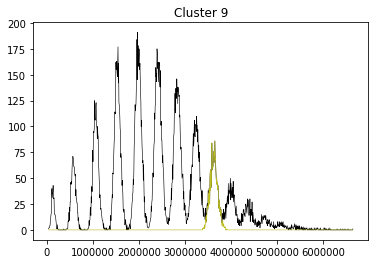

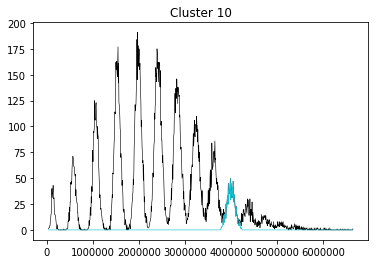

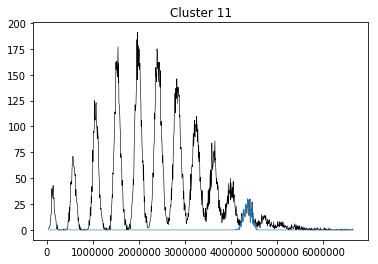

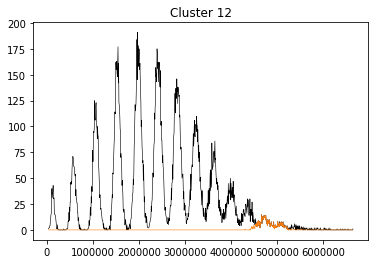

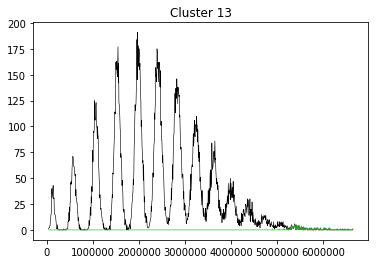

In [92]:
#%matplotlib notebook

#Creating a histogram for the whole data
area_hist, bin_edges = np.histogram(traces_pca['area'], bins=1000)
bin_x = [(bin_edges[i+1] + bin_edges[i])/2 for i in range(len(bin_edges)-1)]
plt.figure('all_clusters', figsize=(11,6))
plt.xlabel('Area ($10^6$ a.u.)', fontsize=12)
plt.ylabel('Total counts', fontsize=12)
plt.xticks([0,1000000,2000000,3000000,4000000,5000000,6000000],[0,1,2,3,4,5,6])
plt.plot(bin_x, area_hist, color='black', lw=0.6)

#Using the same bin_edges to create individual histograms for each cluster, and calculate number distribution
cluster_totals = np.zeros(n_clusters)

for i in range(n_clusters):
    # calculating a histogram for each cluster
    area_hist_i, bin_edges_i = np.histogram(traces_pca[np.where(traces_pca['cluster_pca'] == i)]['area'], \
                                         bins=bin_edges)
    # storing totals
    cluster_totals[i] = sum(area_hist_i)
    
    # plotting each cluster in the 'all' figure
    plt.figure('all_clusters')
    color_code = 'C' + str(i%10)
    plt.plot(bin_x, area_hist_i, color=color_code, lw=0.6)
    
    # plotting each cluster in a separate figure
    plt.figure(str(i+1))
    titlei = 'Cluster ' + str(i+1)
    plt.title(titlei)
    plt.plot(bin_x, area_hist, color='black', lw=0.6)
    plt.plot(bin_x, area_hist_i, color=color_code, lw=0.6)

    
cluster_weights = np.divide(cluster_totals, traces['samples'].shape[0])

In [93]:
# Create PCA predictions dataframe and add pca_df columns
preds_pca_df = pd.DataFrame(preds_pca, columns=['Cluster_PCA'])
pca_df = preds_pca_df.join(pca_df)

In [105]:
pca_df.head()

,Cluster_PCA,Area,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6
0,3,1481619,-167026.074390,-17001.721942,36503.798199,-7098.624453,21383.103158,5148.420575
1,7,3220880,143145.494752,3985.377956,-23506.378447,3976.070503,12835.302312,-4303.774012
2,8,3633324,192623.259433,25979.848559,-12348.461571,-20153.986744,-21755.266087,-5385.749648
3,7,3174663,137697.550835,-1941.299886,-24262.346723,-1676.969783,21744.510249,4719.803664
4,6,2784157,68130.908516,-38579.130933,-3172.488966,2671.512663,8055.865942,14561.566753


### Model Evaluation and Validation

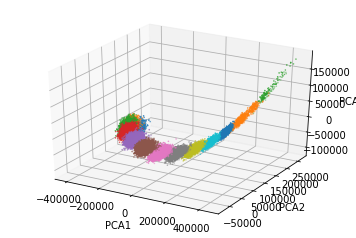

In [95]:
# do a 3d scatterplot colored by cluster
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure().gca(projection='3d')

threedee.set_xlabel('PCA1')
threedee.set_ylabel('PCA2')
threedee.set_zlabel('PCA3')

for i in range(n_clusters):
    color_code = 'C' + str(i%10)
    pca_df_i = pca_df.loc[pca_df['Cluster_PCA'] == i][:15000]
    threedee.scatter(pca_df_i['PCA1'], pca_df_i['PCA2'], pca_df_i['PCA3'], s=0.3, c=color_code)

plt.show()

### Justification

I will now evaluate the clusters obtained above in comparison with the area-based binning, relative to the expected Poisson distribution of photon numbers. This will be done via a maximum likelihood fit of each histogram to the Poissonian pdf.

Since the dataset is too small and noisy to correctly classify clusters photon numbers n >= 12, I will consider only n < 12.

The best-fit mean photon number for the Poisson distribution with area classification is  6.113073981119791 +- 0.03531768671127882
The best-fit mean photon number for the Poisson distribution with GMM classification is  6.106658882524233 +- 0.03418873808100126


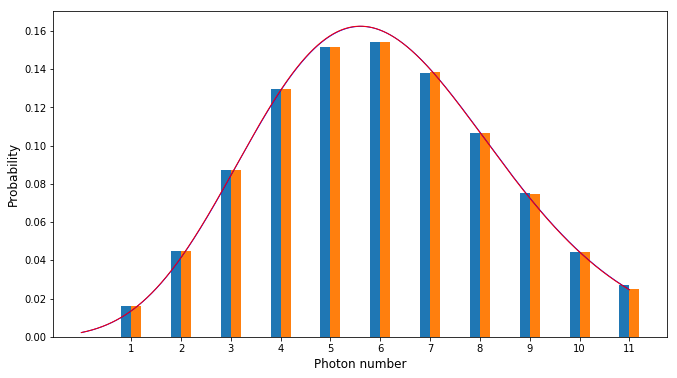

In [102]:
#%matplotlib notebook

# Some of the following code adapted from https://stackoverflow.com/questions/25828184/fitting-to-poisson-histogram
from scipy.optimize import curve_fit
from scipy.special import factorial

# plotting bar charts of the photon numbers found using both methods
n = np.arange(1,12)

class_probs = class_weights[:len(n)]
cluster_probs = cluster_weights[:len(n)]

plt.figure(figsize=(11,6))
plt.xlabel('Photon number', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xticks(np.arange(1, 12, step=1))

plt.bar(n-0.1, class_probs, width=0.2)
plt.bar(n+0.1, cluster_probs, width=0.2)

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

# fit area class_weights with curve_fit
parameters, cov_matrix = curve_fit(poisson, n, class_probs, p0=6) 
par_err_class = np.sqrt(np.diag(cov_matrix))
print("The best-fit mean photon number for the Poisson distribution with area classification is ", parameters[0], "+-", par_err_class[0])

# plot poisson distribution with fitted parameter
x_plot = np.linspace(0, len(n), 1000)
plt.plot(x_plot, poisson(x_plot, *parameters), 'b-', lw=1)

# fit cluster_weights with curve_fit
parameters, cov_matrix = curve_fit(poisson, n, cluster_probs, p0=6) 
par_err_cluster = np.sqrt(np.diag(cov_matrix))
print("The best-fit mean photon number for the Poisson distribution with GMM classification is ", parameters[0], "+-", par_err_cluster[0])

# plot poisson distribution with fitted parameter
x_plot = np.linspace(0, len(n), 1000)
plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=1)
plt.show()



## Conclusion

### Free-form visualisation

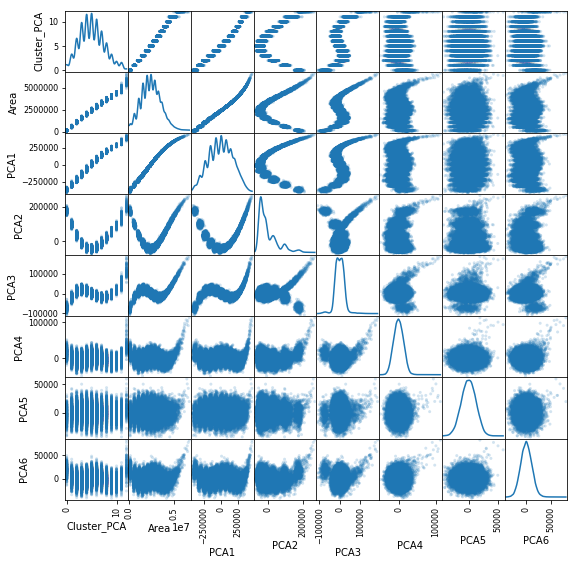

In [107]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(pca_df, alpha=0.2, figsize=(9,9), diagonal='kde');